In [1]:
# import geomloss

In [11]:
import pandas as pd
from sdv.single_table import TVAESynthesizer

from domias.evaluator import evaluate_performance
from domias.models.generator import GeneratorInterface
from domias.models.ctgan import CTGAN



from scipy import stats
from scipy.stats import multivariate_normal


import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing, fetch_covtype, load_digits

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_uci = pd.read_csv(r'C:\Users\jordy\OneDrive\MSc_Python\Individual_Project\Data\UCI_Credit_Card.csv')
df_uci.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
#convert dataframe to array
arr_uci = np.array(df_uci.iloc[:, 1:-1])
arr_uci.shape

(30000, 23)

In [4]:
def get_dataset() -> np.ndarray:
    def data_loader() -> np.ndarray:
        scaler = StandardScaler()
        X =arr_uci
        np.random.shuffle(X)
        return scaler.fit_transform(X)

    return data_loader()

In [5]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 10000 #held out set
training_epochs = [100, 500, 1000, 2000, 3000]
training_sizes = [10000]
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_size = 200 #same as synthetic_sizes

method = "CTGAN"

# Create a dictionary to store the results
results = {}

# Set the number of iterations
num_iterations = 3

for iteration in range(1, num_iterations+1):
    # Initialize the result dictionary for the current iteration
    iteration_results = {}
    
    for training_size in training_sizes:
        # Initialize the result dictionary for the current training size
        size_results = {}
        
        for training_epoch in training_epochs:
            generator = get_generator(
                gan_method=method,
                epochs=training_epoch,
            )
    
            perf = evaluate_performance(
                generator,
                dataset,
                training_size,
                reference_set_size,
                training_epochs=training_epoch,
                synthetic_sizes=[gen_size],
                density_estimator=density_estimator,
            )
            
            # Store the MIA performance for the current training size and epoch
            size_results[training_epoch] = perf[gen_size]["MIA_performance"]
        
        # Store the results for the current training size
        iteration_results[training_size] = size_results
    
    # Store the results for the current iteration
    results[iteration] = iteration_results

# Print the results
for iteration, iteration_results in results.items():
    print(f"Iteration {iteration}:")
    for training_size, size_results in iteration_results.items():
        print(f"Training Size {training_size}:")
        for training_epoch, mia_performance in size_results.items():
            print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
        print()


Iteration 1:
Training Size 10000:
Training Epoch 100: MIA Performance = {'ablated_eq1': {'accuracy': 0.493, 'aucroc': 0.49233784499999994}, 'ablated_eq2': {'accuracy': 0.5024, 'aucroc': 0.499786675}, 'LOGAN_D1': {'accuracy': 0.4998, 'aucroc': 0.503088285}, 'MC': {'accuracy': 0.4907, 'aucroc': 0.493387315}, 'gan_leaks': {'accuracy': 0.4907, 'aucroc': 0.49053705999999997}, 'gan_leaks_cal': {'accuracy': 0.4936, 'aucroc': 0.493554545}, 'LOGAN_0': {'accuracy': 0.4986, 'aucroc': 0.49453298500000004}, 'eq1': {'accuracy': 0.493, 'aucroc': 0.49233784499999994}, 'domias': {'accuracy': 0.5004, 'aucroc': 0.498839995}}
Training Epoch 500: MIA Performance = {'ablated_eq1': {'accuracy': 0.4929, 'aucroc': 0.49130089}, 'ablated_eq2': {'accuracy': 0.4986, 'aucroc': 0.49583258999999996}, 'LOGAN_D1': {'accuracy': 0.4982, 'aucroc': 0.50067266}, 'MC': {'accuracy': 0.4936, 'aucroc': 0.493523355}, 'gan_leaks': {'accuracy': 0.4936, 'aucroc': 0.489840285}, 'gan_leaks_cal': {'accuracy': 0.4965, 'aucroc': 0.49287

In [ ]:
#16:47

In [17]:
output = pd.DataFrame([], columns=["iteration", "epoch", "src", "aucroc"])

for iteration in range(1, num_iterations + 1):
    for training_epoch in training_epochs:
        epoch_res = results[iteration][training_size][training_epoch]
        perf = epoch_res  # Assuming perf is the correct value for accuracy

        for key in perf:
            output = pd.concat(
                [
                    output,
                    pd.DataFrame(
                        [
                            [iteration, training_epoch, key, perf[key]["aucroc"]],
                        ],
                        columns=["iteration", "epoch", "src", "aucroc"],
                    ),
                ]
            )
output

,iteration,epoch,src,aucroc
0,1,100,ablated_eq1,0.492338
0,1,100,ablated_eq2,0.499787
0,1,100,LOGAN_D1,0.503088
0,1,100,MC,0.493387
0,1,100,gan_leaks,0.490537
...,...,...,...,...
0,3,3000,gan_leaks,0.490854
0,3,3000,gan_leaks_cal,0.494151
0,3,3000,LOGAN_0,0.499211
0,3,3000,eq1,0.489205


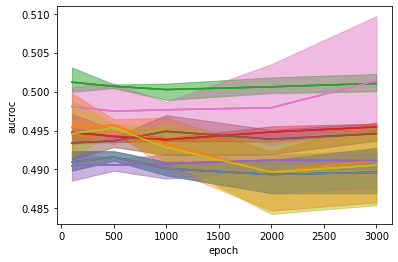

In [49]:
import seaborn as sns
for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output, x="epoch", y="aucroc", hue="src", legend=False)


In [15]:
output_dom = output[output['src']=='domias']
output_dom

,iteration,epoch,src,aucroc
0,1,100,domias,0.498840
0,1,500,domias,0.495372
0,1,1000,domias,0.491963
0,1,2000,domias,0.484296
0,1,3000,domias,0.495604
0,2,100,domias,0.491563
0,2,500,domias,0.494845
0,2,1000,domias,0.491200
0,2,2000,domias,0.493708
0,2,3000,domias,0.485409


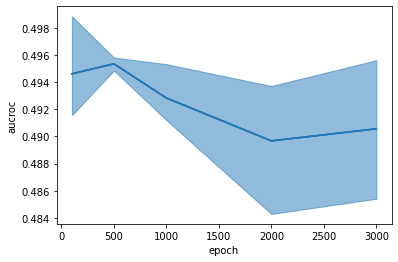

In [25]:
import seaborn as sns
for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_dom, x="epoch", y="aucroc", hue="src", legend=False)

## Sorting legend duplicate issue

In [38]:
mean_output = pd.DataFrame(output.groupby(['src', 'epoch'])['aucroc'].mean())
#mean_output.reset_index('epoch', inplace=True)
mean_output

aucroc
src           epoch          
LOGAN_0       100    0.498085
              500    0.497484
              1000   0.497665
              2000   0.497927
              3000   0.501377
LOGAN_D1      100    0.501203
              500    0.500678
              1000   0.500262
              2000   0.500616
              3000   0.501046
MC            100    0.494749
              500    0.494256
              1000   0.493820
              2000   0.494814
              3000   0.495464
ablated_eq1   100    0.490946
              500    0.491589
              1000   0.490122
              2000   0.489358
              3000   0.489638
ablated_eq2   100    0.495413
              500    0.495687
              1000   0.493258
              2000   0.489661
              3000   0.491145
domias        100    0.494605
              500    0.495339
              1000   0.492826
              2000   0.489671
              3000   0.490557
eq1           100    0.490946
              500    0.491589
              1000   0.490122
              2000   0.489358
              3000   0.489638
gan_leaks     100    0.490495
              500    0.490583
              1000   0.490741
              2000   0.491193
              3000   0.491132
gan_leaks_cal 100    0.493415
              500    0.493670
              1000   0.494901
              2000   0.493893
              3000   0.494593

## Varying Training size

In [55]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_size = 10000 #held out set
training_epochs = [2000]
training_sizes = [100, 500, 1000, 3000, 5000, 10000]
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_size = 200 #same as synthetic_sizes

method = "CTGAN"

# Create a dictionary to store the results
results = {}

# Set the number of iterations
num_iterations = 3

for iteration in range(1, num_iterations+1):
    # Initialize the result dictionary for the current iteration
    iteration_results = {}
    
    for training_size in training_sizes:
        # Initialize the result dictionary for the current training size
        size_results = {}
        
        for training_epoch in training_epochs:
            generator = get_generator(
                gan_method=method,
                epochs=training_epoch,
            )
    
            perf = evaluate_performance(
                generator,
                dataset,
                training_size,
                reference_set_size,
                training_epochs=training_epoch,
                synthetic_sizes=[gen_size],
                density_estimator=density_estimator,
            )
            
            # Store the MIA performance for the current training size and epoch
            size_results[training_epoch] = perf[gen_size]["MIA_performance"]
        
        # Store the results for the current training size
        iteration_results[training_size] = size_results
    
    # Store the results for the current iteration
    results[iteration] = iteration_results

# Print the results
for iteration, iteration_results in results.items():
    print(f"Iteration {iteration}:")
    for training_size, size_results in iteration_results.items():
        print(f"Training Size {training_size}:")
        for training_epoch, mia_performance in size_results.items():
            print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
        print()


Iteration 1:
Training Size 100:
Training Epoch 2000: MIA Performance = {'ablated_eq1': {'accuracy': 0.56, 'aucroc': 0.5786}, 'ablated_eq2': {'accuracy': 0.61, 'aucroc': 0.6131}, 'LOGAN_D1': {'accuracy': 0.5, 'aucroc': 0.5082}, 'MC': {'accuracy': 0.56, 'aucroc': 0.5888000000000001}, 'gan_leaks': {'accuracy': 0.56, 'aucroc': 0.5656}, 'gan_leaks_cal': {'accuracy': 0.59, 'aucroc': 0.5871}, 'LOGAN_0': {'accuracy': 0.57, 'aucroc': 0.5609999999999999}, 'eq1': {'accuracy': 0.56, 'aucroc': 0.5786}, 'domias': {'accuracy': 0.6, 'aucroc': 0.6037}}

Training Size 500:
Training Epoch 2000: MIA Performance = {'ablated_eq1': {'accuracy': 0.504, 'aucroc': 0.51614}, 'ablated_eq2': {'accuracy': 0.498, 'aucroc': 0.504924}, 'LOGAN_D1': {'accuracy': 0.498, 'aucroc': 0.5029319999999999}, 'MC': {'accuracy': 0.52, 'aucroc': 0.516198}, 'gan_leaks': {'accuracy': 0.52, 'aucroc': 0.521588}, 'gan_leaks_cal': {'accuracy': 0.518, 'aucroc': 0.52406}, 'LOGAN_0': {'accuracy': 0.512, 'aucroc': 0.506044}, 'eq1': {'accurac

In [63]:
output_training = pd.DataFrame([], columns=["iteration", "training_size", "epoch", "src", "aucroc"])

for iteration in range(1, num_iterations + 1):
    for training_size in training_sizes:
        training_size_res = results[iteration][training_size][training_epoch]
        perf = training_size_res  # Assuming perf is the correct value for accuracy

        for key in perf:
            output_training = pd.concat(
                [
                    output_training,
                    pd.DataFrame(
                        [
                            [iteration, training_size, training_epoch, key, perf[key]["aucroc"]],
                        ],
                        columns=["iteration", "training_size", "epoch", "src", "aucroc"],
                    ),
                ]
            )
output_training

,iteration,training_size,epoch,src,aucroc
0,1,100,2000,ablated_eq1,0.578600
0,1,100,2000,ablated_eq2,0.613100
0,1,100,2000,LOGAN_D1,0.508200
0,1,100,2000,MC,0.588800
0,1,100,2000,gan_leaks,0.565600
...,...,...,...,...,...
0,3,10000,2000,gan_leaks,0.505200
0,3,10000,2000,gan_leaks_cal,0.505184
0,3,10000,2000,LOGAN_0,0.501588
0,3,10000,2000,eq1,0.506138


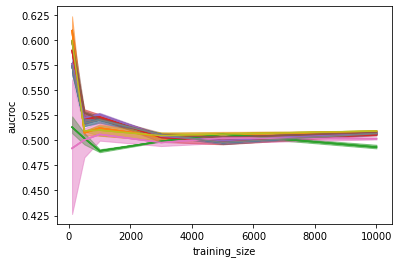

In [61]:
for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_training, x="training_size", y="aucroc", hue="src", legend=False)


In [86]:
output_training.src.unique()

array(['ablated_eq1', 'ablated_eq2', 'LOGAN_D1', 'MC', 'gan_leaks',
       'gan_leaks_cal', 'LOGAN_0', 'eq1', 'domias'], dtype=object)

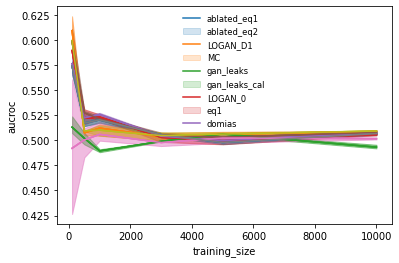

In [91]:
#With unique legend
labels = output_training.src.unique()

fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_training, x="training_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = labels, frameon=False, loc='best', fontsize='small')
plt.show()

In [64]:
output_training_dom = output_training[output_training['src']=='domias']
output_training_dom

,iteration,training_size,epoch,src,aucroc
0,1,100,2000,domias,0.603700
0,1,500,2000,domias,0.509120
0,1,1000,2000,domias,0.514854
0,1,3000,2000,domias,0.507992
0,1,5000,2000,domias,0.507374
0,1,10000,2000,domias,0.509332
0,2,100,2000,domias,0.608700
0,2,500,2000,domias,0.509908
0,2,1000,2000,domias,0.511242
0,2,3000,2000,domias,0.506053


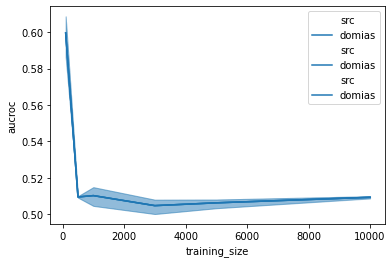

In [71]:
#Ploting domias across varying training sizes without baseline examples
for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_training_dom, x="training_size", y="aucroc", hue="src")

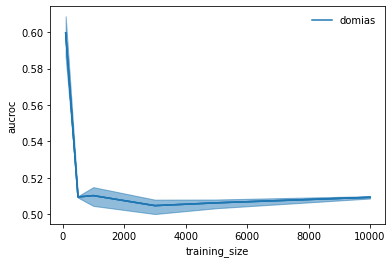

In [84]:
#With unique legend
fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_training_dom, x="training_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = ['domias'], frameon=False)
plt.show()


# Varying reference set size

In [5]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_sizes = [100, 500, 1000] #held out set
training_epochs = [2000]
training_sizes = [10000] #D-mem
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_size = 200 #same as synthetic_sizes -> D_syn

method = "CTGAN"

# Create a dictionary to store the results
results = {}

# Set the number of iterations
num_iterations = 3

for iteration in range(1, num_iterations+1):
    # Initialize the result dictionary for the current iteration
    iteration_results = {}
    
    
    for reference_set_size in reference_set_sizes:
        size_results = {}
    
        for training_size in training_sizes:
            # Initialize the result dictionary for the current training size

            for training_epoch in training_epochs:
                generator = get_generator(
                    gan_method=method,
                    epochs=training_epoch,
                )

                perf = evaluate_performance(
                    generator,
                    dataset,
                    training_size,
                    reference_set_size,
                    training_epochs=training_epoch,
                    synthetic_sizes=[gen_size],
                    density_estimator=density_estimator,
                )

                # Store the MIA performance for the current training size and epoch
                size_results[training_epoch] = perf[gen_size]["MIA_performance"]

            # Store the results for the current training size
            iteration_results[reference_set_size] = size_results

        # Store the results for the current iteration
        results[iteration] = iteration_results

# Print the results
for iteration, iteration_results in results.items():
    print(f"Iteration {iteration}:")
    for reference_set_size, size_results in iteration_results.items():
        print(f"Training Size {training_size}:")
        for training_epoch, mia_performance in size_results.items():
            print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
        print()


p_G_evaluated
[4.96751598e-08 1.75134752e-07 1.87130476e-09 ... 8.70782424e-07
 6.11849141e-10 3.47410435e-09]
p_R_evaluated
[4.45696684e-04 1.14105695e-04 7.22043296e-06 ... 1.10804342e-03
 1.25082356e-06 2.35038743e-09]
Synth_set
            0         1         2         3         4         5         6  \
0   -1.099229  0.810692  0.184463  0.857186 -0.506901  0.014437  0.110640   
1    1.406659 -1.234871 -1.083589 -1.058717  0.885850 -0.872003 -0.725055   
2    1.899780  0.808305 -1.085254  0.858346 -0.400845 -1.769498 -1.561179   
3    0.532667  0.810425 -1.083077  0.859883 -0.317274  0.015253  0.114107   
4   -0.865014  0.809317 -1.081474  0.859001 -0.353766  0.013817  0.111601   
..        ...       ...       ...       ...       ...       ...       ...   
195  2.126845  0.809726  0.185270 -1.056522  0.288822  0.013473  0.111196   
196  1.398606  0.808230 -1.085756  0.858107 -0.257325  0.014350  0.110306   
197 -0.282031 -1.232492  1.446841 -1.055970  2.079696  0.015197  0.113276  

p_G_evaluated
[9.33543049e-08 2.44718633e-08 1.31289862e-07 ... 1.18229709e-06
 1.45872791e-08 2.19198138e-09]
p_R_evaluated
[4.45696684e-04 1.14105695e-04 7.22043296e-06 ... 1.10804342e-03
 1.25082356e-06 2.35038743e-09]
Synth_set
            0         1         2         3         4         5         6  \
0   -0.968042  0.808808  1.454822  0.858466 -1.019418 -0.875870  0.111109   
1   -0.039962  0.808070  1.447924 -1.062902  0.108805 -1.762253 -1.561337   
2    0.063357  0.808318  0.185842  0.857764 -0.964037  0.013722 -0.726553   
3   -0.863195  0.808879 -1.078627 -1.059476  0.802686  0.018050  0.110087   
4   -0.969935  0.808629  1.450266 -1.064367  0.226575 -0.871469 -0.722958   
..        ...       ...       ...       ...       ...       ...       ...   
195 -0.702316  0.808337  0.186409  0.857517 -0.308248  0.015178  0.109385   
196 -0.161622  0.807767  0.188015 -1.057553  0.380140  0.015538  0.108989   
197 -0.497708  0.808892  0.183709  0.854693 -1.089513  0.015655  0.109595  

p_G_evaluated
[1.35164580e-05 3.49637425e-06 8.00948158e-08 ... 4.57872116e-05
 1.91824984e-09 4.60004645e-09]
p_R_evaluated
[4.45696684e-04 1.14105695e-04 7.22043296e-06 ... 1.10804342e-03
 1.25082356e-06 2.35038743e-09]
Synth_set
            0         1         2         3         4         5         6  \
0    2.766962 -1.234671  1.454728 -1.061879  2.034749 -1.779682 -1.563944   
1    0.324242  0.809478  0.190512  0.857268 -0.957974  0.011486  0.112848   
2    0.899400 -1.232617  0.185449  0.854278  0.278119  0.010794  0.111325   
3   -1.095799  0.810358  0.184509  0.854582 -1.054782  0.011297  0.113481   
4   -0.242830  0.809610  0.183811 -1.061748  0.686758  0.011839  0.111623   
..        ...       ...       ...       ...       ...       ...       ...   
195 -0.478118  0.808595  0.185316 -1.059989  0.444463  1.788944  0.110639   
196 -0.683269 -1.232569  0.186010 -1.059332 -0.917223  0.011629  0.109834   
197  1.445391  0.811514  0.186296  0.859554 -0.599486  0.016627  0.111094  

In [6]:
results

{1: {100: {2000: {'ablated_eq1': {'accuracy': 0.5021, 'aucroc': 0.500624755},
    'ablated_eq2': {'accuracy': 0.5051, 'aucroc': 0.505028585},
    'LOGAN_D1': {'accuracy': 0.4961, 'aucroc': 0.494717535},
    'MC': {'accuracy': 0.5051, 'aucroc': 0.504117005},
    'gan_leaks': {'accuracy': 0.5051, 'aucroc': 0.50198173},
    'gan_leaks_cal': {'accuracy': 0.5065, 'aucroc': 0.5067427},
    'LOGAN_0': {'accuracy': 0.5, 'aucroc': 0.503625785},
    'eq1': {'accuracy': 0.5021, 'aucroc': 0.500624755},
    'domias': {'accuracy': 0.5039, 'aucroc': 0.503697445}}},
  500: {2000: {'ablated_eq1': {'accuracy': 0.4974, 'aucroc': 0.49828439},
    'ablated_eq2': {'accuracy': 0.5006, 'aucroc': 0.49980188},
    'LOGAN_D1': {'accuracy': 0.4938, 'aucroc': 0.493607995},
    'MC': {'accuracy': 0.4977, 'aucroc': 0.49876305000000004},
    'gan_leaks': {'accuracy': 0.4977, 'aucroc': 0.49942059},
    'gan_leaks_cal': {'accuracy': 0.5025, 'aucroc': 0.504720575},
    'LOGAN_0': {'accuracy': 0.4994, 'aucroc': 0.4983410

In [7]:
# Print the results
for iteration, iteration_results in results.items():
    print(f"Iteration {iteration}:")
    for reference_set_size, size_results in iteration_results.items():
        print(f"Training Size {reference_set_size}:")
        for training_epoch, mia_performance in size_results.items():
            print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
        print()

Iteration 1:
Training Size 100:
Training Epoch 2000: MIA Performance = {'ablated_eq1': {'accuracy': 0.5021, 'aucroc': 0.500624755}, 'ablated_eq2': {'accuracy': 0.5051, 'aucroc': 0.505028585}, 'LOGAN_D1': {'accuracy': 0.4961, 'aucroc': 0.494717535}, 'MC': {'accuracy': 0.5051, 'aucroc': 0.504117005}, 'gan_leaks': {'accuracy': 0.5051, 'aucroc': 0.50198173}, 'gan_leaks_cal': {'accuracy': 0.5065, 'aucroc': 0.5067427}, 'LOGAN_0': {'accuracy': 0.5, 'aucroc': 0.503625785}, 'eq1': {'accuracy': 0.5021, 'aucroc': 0.500624755}, 'domias': {'accuracy': 0.5039, 'aucroc': 0.503697445}}

Training Size 500:
Training Epoch 2000: MIA Performance = {'ablated_eq1': {'accuracy': 0.4974, 'aucroc': 0.49828439}, 'ablated_eq2': {'accuracy': 0.5006, 'aucroc': 0.49980188}, 'LOGAN_D1': {'accuracy': 0.4938, 'aucroc': 0.493607995}, 'MC': {'accuracy': 0.4977, 'aucroc': 0.49876305000000004}, 'gan_leaks': {'accuracy': 0.4977, 'aucroc': 0.49942059}, 'gan_leaks_cal': {'accuracy': 0.5025, 'aucroc': 0.504720575}, 'LOGAN_0':

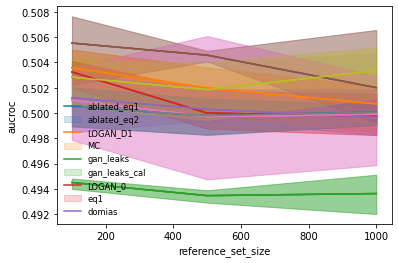

In [17]:
#With unique legend
from matplotlib import pyplot as plt
import seaborn as sns

labels = output_ref.src.unique()

fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_ref, x="reference_set_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = labels, frameon=False, loc='best', fontsize='small')
plt.show()

In [19]:
#domias only
output_ref_dom = output_ref[output_ref['src']=='domias']


In [20]:
output_ref_dom

,iteration,reference_set_size,epoch,src,aucroc
0,1,100,2000,domias,0.503697
0,1,500,2000,domias,0.499443
0,1,1000,2000,domias,0.505192
0,2,100,2000,domias,0.504206
0,2,500,2000,domias,0.503989
0,2,1000,2000,domias,0.501165
0,3,100,2000,domias,0.500616
0,3,500,2000,domias,0.502132
0,3,1000,2000,domias,0.503693


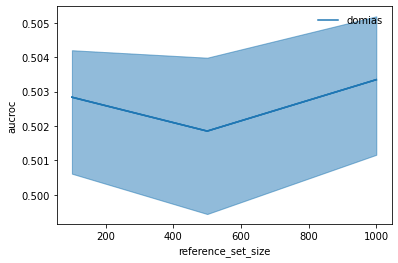

In [23]:
#With unique legend
fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_ref_dom, x="reference_set_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = ['domias'], frameon=False)
plt.show()

## Varying gen size (D_mem)

In [24]:
def get_generator(
    gan_method: str = "CTGAN",
    epochs: int = 1000,
    seed: int = 0,
) -> GeneratorInterface:
    class LocalGenerator(GeneratorInterface):
        def __init__(self) -> None:
            if gan_method == "TVAE":
                syn_model = TVAESynthesizer(metadata, epochs=epochs)
            elif gan_method == "CTGAN":
                syn_model = CTGAN(epochs=epochs)
            elif gan_method == "KDE":
                syn_model = None
            else:
                raise RuntimeError()
            self.method = gan_method
            self.model = syn_model
                

        def fit(self, data: pd.DataFrame) -> "LocalGenerator":
            if self.method == "KDE":
                self.model = stats.gaussian_kde(np.transpose(data))
            else:
                self.model.fit(data)
            return self

        def generate(self, count: int) -> pd.DataFrame:
            
            if gan_method == "KDE":
                samples = pd.DataFrame(self.model.resample(count).transpose(1, 0))
            elif gan_method == "TVAE":
                samples = self.model.sample(count)
            elif gan_method == "CTGAN":
                samples = self.model.generate(count)
            else:
                raise RuntimeError()

            return samples
            
            #return self.model.sample(count)

    return LocalGenerator()


#Loading metadata from dataset for use in TVAESynthesizer
dataset = get_dataset()
df_dataset = pd.DataFrame(dataset)
df_dataset.rename(columns={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}, inplace = True)

from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_dataset)






"""
Args:
    generator: GeneratorInterface
        Generator with the `fit` and `generate` methods. The generator MUST not be fitted.
    dataset: int
        The evaluation dataset, used to derive the training and test datasets.
    training_size: int
        The split for the training (member) dataset out of `dataset`
    reference_size: int
        The split for the reference dataset out of `dataset`.
    training_epochs: int
        Training epochs
    synthetic_sizes: List[int]
        For how many synthetic samples to test the attacks.

"""

"""
CTGAN Args:

embedding_dim: int = 128,
generator_dim: Tuple = (256, 256),
discriminator_dim: Tuple = (256, 256),
generator_lr: float = 2e-4,
generator_decay: float = 1e-6,
discriminator_lr: float = 2e-4,
discriminator_decay: float = 1e-6,
batch_size: int = 500,
discriminator_steps: int = 1,
log_frequency: bool = True,
verbose: bool = False,
epochs: int = 300,
pac: int = 1,
cuda: bool = True,



"""


# mem_set_size = 1000 -> originally what training size was
reference_set_sizes = 100 #held out set
training_epochs = [2000]
training_sizes = [100] #D-mem
#synthetic_sizes = [200]
density_estimator = "kde"  # prior, kde, bnaf
gen_sizes = [100, 200] #same as synthetic_sizes -> D_syn

method = "CTGAN"

# Create a dictionary to store the results
results = {}

# Set the number of iterations
num_iterations = 1

for iteration in range(1, num_iterations+1):
    # Initialize the result dictionary for the current iteration
    iteration_results = {}
    
    
    for gen_size in gen_sizes:
        size_results = {}
    
        for training_size in training_sizes:
            # Initialize the result dictionary for the current training size

            for training_epoch in training_epochs:
                generator = get_generator(
                    gan_method=method,
                    epochs=training_epoch,
                )

                perf = evaluate_performance(
                    generator,
                    dataset,
                    training_size,
                    reference_set_size,
                    training_epochs=training_epoch,
                    synthetic_sizes=[gen_size],
                    density_estimator=density_estimator,
                )

                # Store the MIA performance for the current training size and epoch
                size_results[training_epoch] = perf[gen_size]["MIA_performance"]

            # Store the results for the current training size
            iteration_results[gen_size] = size_results

        # Store the results for the current iteration
        results[iteration] = iteration_results

# Print the results
for iteration, iteration_results in results.items():
    print(f"Iteration {iteration}:")
    for gen_size, size_results in iteration_results.items():
        print(f"Training Size {training_size}:")
        for training_epoch, mia_performance in size_results.items():
            print(f"Training Epoch {training_epoch}: MIA Performance = {mia_performance}")
        print()


p_G_evaluated
[1.08501990e-012 3.68844443e-006 6.39374747e-022 3.83042929e-010
 6.07903495e-014 2.01049823e-012 1.54261478e-007 4.73676402e-008
 9.94104253e-008 3.38883609e-006 2.68157417e-007 1.56397264e-010
 8.46268573e-007 2.04243271e-009 4.32978324e-007 1.29631989e-008
 1.66020290e-010 5.39167987e-013 4.81307373e-017 2.77940866e-006
 1.58749417e-008 2.38767251e-012 1.06829489e-009 3.17255651e-018
 7.13058755e-020 1.32448150e-006 1.63788246e-010 5.51534708e-006
 2.94371475e-007 1.03862778e-008 7.66884358e-009 1.88821962e-007
 1.28282753e-009 3.06472948e-008 3.45914945e-012 8.06213485e-009
 3.22934612e-007 7.89024619e-013 4.77768122e-009 7.40223369e-016
 1.82931205e-124 4.15830397e-009 5.76648879e-013 5.58768409e-015
 1.17442616e-006 7.79255070e-009 9.52921925e-007 7.39329560e-024
 1.03044388e-007 3.49423833e-012 4.79358115e-008 0.00000000e+000
 6.16506214e-010 8.13797491e-010 2.63911993e-007 2.98688660e-013
 2.62603043e-006 7.96922779e-010 9.87229603e-008 5.07676718e-006
 1.89997494

p_G_evaluated
[7.55795691e-014 6.24873157e-007 7.06236808e-015 4.07894470e-012
 1.81031722e-011 3.41638301e-013 4.31462249e-008 6.70916609e-010
 2.62413625e-009 4.61483947e-007 5.16659283e-009 1.18272671e-011
 1.07181806e-007 2.61328488e-010 2.89052288e-007 8.61422987e-009
 2.92695693e-012 6.25642512e-014 2.37396813e-013 2.85208394e-008
 1.00185128e-007 2.74220239e-013 3.66683560e-009 2.82753481e-009
 5.20406343e-029 5.81384146e-007 1.73681512e-008 7.96987933e-008
 1.00725743e-006 4.61319868e-011 6.95782511e-008 1.08909894e-008
 2.08220581e-007 6.27923791e-007 5.54313971e-012 2.73165591e-010
 8.11654649e-008 6.88240304e-010 6.13138540e-008 3.23465141e-014
 5.04131950e-014 1.45901563e-007 3.13683976e-015 3.87076633e-014
 3.20554218e-008 7.44343857e-009 3.92766708e-007 7.30254834e-015
 3.46790724e-010 4.63676955e-010 3.22172804e-008 1.35479271e-033
 1.51996495e-011 1.16816218e-009 5.62858289e-007 1.13561150e-011
 3.83053532e-007 2.98861406e-008 1.01301270e-008 1.41880172e-006
 3.07278722

In [31]:
output_gen = pd.DataFrame([], columns=["iteration", "gen_size", "epoch", "src", "aucroc"])

for iteration in range(1, num_iterations + 1):
    for gen_size in gen_sizes:
        gen_set_size_res = results[iteration][gen_size][training_epoch]
        perf = gen_set_size_res  # Assuming perf is the correct value for accuracy

        for key in perf:
            output_gen = pd.concat(
                [
                    output_gen,
                    pd.DataFrame(
                        [
                            [iteration, gen_size, training_epoch, key, perf[key]["aucroc"]],
                        ],
                        columns=["iteration", "gen_size", "epoch", "src", "aucroc"],
                    ),
                ]
            )
output_gen

,iteration,gen_size,epoch,src,aucroc
0,1,100,2000,ablated_eq1,0.52970
0,1,100,2000,ablated_eq2,0.54930
0,1,100,2000,LOGAN_D1,0.51790
0,1,100,2000,MC,0.54215
0,1,100,2000,gan_leaks,0.54660
0,1,100,2000,gan_leaks_cal,0.62020
0,1,100,2000,LOGAN_0,0.54640
0,1,100,2000,eq1,0.52970
0,1,100,2000,domias,0.55420
0,1,200,2000,ablated_eq1,0.53870


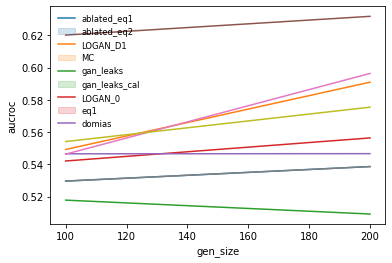

In [32]:
#With unique legend
from matplotlib import pyplot as plt
import seaborn as sns

labels = output_gen.src.unique()

fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_gen, x="gen_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = labels, frameon=False, loc='best', fontsize='small')
plt.show()

In [33]:
#domias only
output_gen_dom = output_gen[output_gen['src']=='domias']
output_gen_dom

,iteration,gen_size,epoch,src,aucroc
0,1,100,2000,domias,0.5542
0,1,200,2000,domias,0.5755


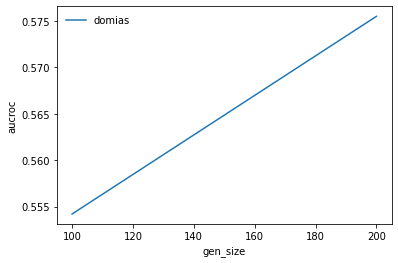

In [34]:
#With unique legend
fig, ax = plt.subplots()

for iteration in range(1, num_iterations + 1):
    sns.lineplot(data=output_gen_dom, x="gen_size", y="aucroc", hue="src", ax=ax, legend=False)

ax.legend(labels = ['domias'], frameon=False)
plt.show()